In [1]:
import sys
import pandas as pd
import numpy as np

# Add the project root directory to Python path
project_root = r'c:\Users\pedro.hun\Documents\repos\option_monitor2'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.orchestrators.df_creator import DFCreator
from src.orchestrators.single_expiry_fitting import SingleExpiry
from src.core.surfaces.ssvi2 import (
    build_default_calibrator, 
    SSVIModel, 
    ObservedSSVISlice,
    summarize_calibration
)
from src.core.visualization.plotters2 import (
    plot_ssvi_slices_2d,
    plot_ssvi_surface_3d_matplotlib,
    plot_ssvi_surface_3d_plotly,
    plot_calibration_diagnostics
)

In [2]:
df_creator = DFCreator()

In [3]:
final_df = df_creator.apply_natural()

Fitting SVI for TTE_days = 3
k_values range: [-0.2295, 0.1000]
w_values range: [0.0005, 0.0277]
weights range: [0.1779, 1.2855]
Initial guess for SVI parameters: [np.float64(0.0005038393182959244), np.float64(0.1650594376391631), np.float64(0.5), np.float64(-0.005721229450137556), np.float64(0.08238610445317321)]
Fitting SVI for TTE_days = 8
k_values range: [-0.0863, 0.1760]
w_values range: [0.0013, 0.0071]
weights range: [0.2054, 2.0746]
Initial guess for SVI parameters: [np.float64(0.0012929720968980886), np.float64(0.04399992599503972), np.float64(-0.5), np.float64(-0.006287076303446771), np.float64(0.06559106611687276)]
Fitting SVI for TTE_days = 18
k_values range: [-0.0464, 0.0899]
w_values range: [0.0032, 0.0212]
weights range: [2.2516, 3.1645]
Initial guess for SVI parameters: [np.float64(0.0032137610123398413), np.float64(0.26390978234932827), np.float64(-0.5), np.float64(-0.030299769720580228), 0.05]
Fitting SVI for TTE_days = 22
k_values range: [-0.2142, 0.4210]
w_values rang

In [ ]:
filtered_df = final_df[~((final_df["TTE_days"]==3) | (final_df["TTE_days"]==27) | (final_df["TTE_days"]==103) | (final_df["TTE_days"]==122))]

Found 24 options with 3 days to expiry
Moneyness range: -0.230 to 0.100


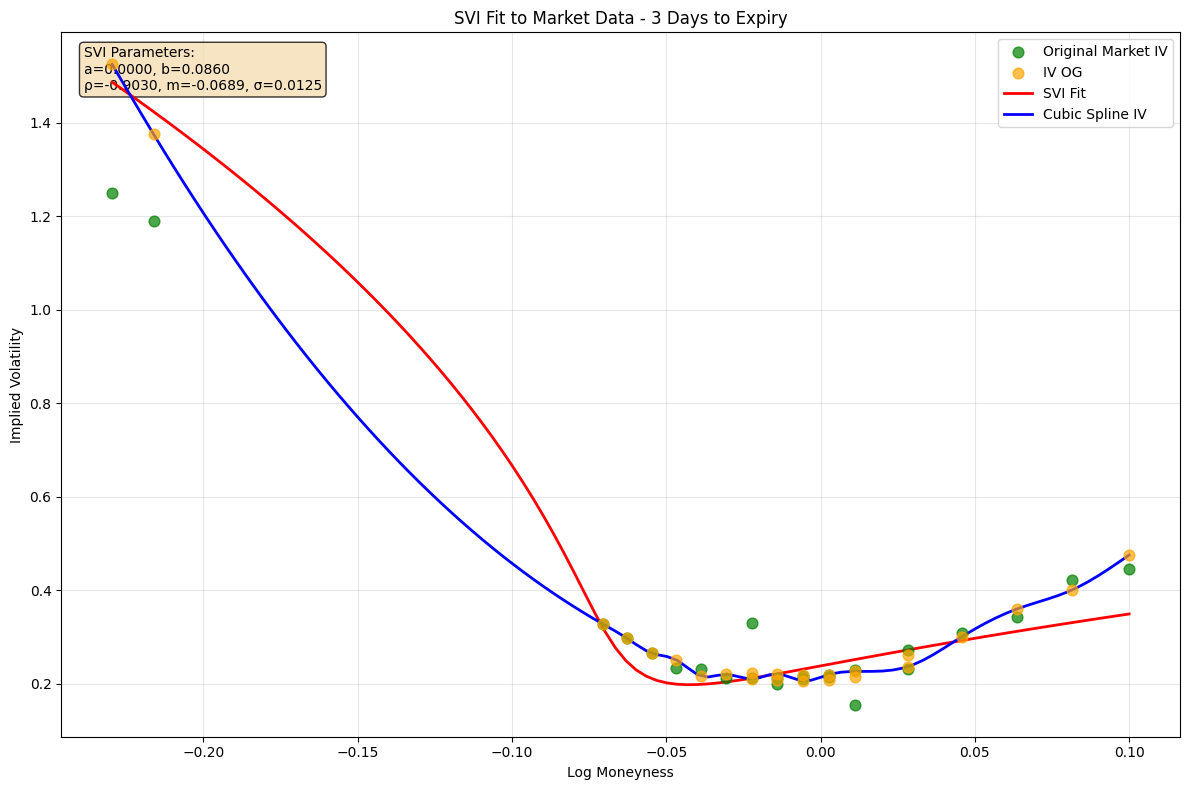

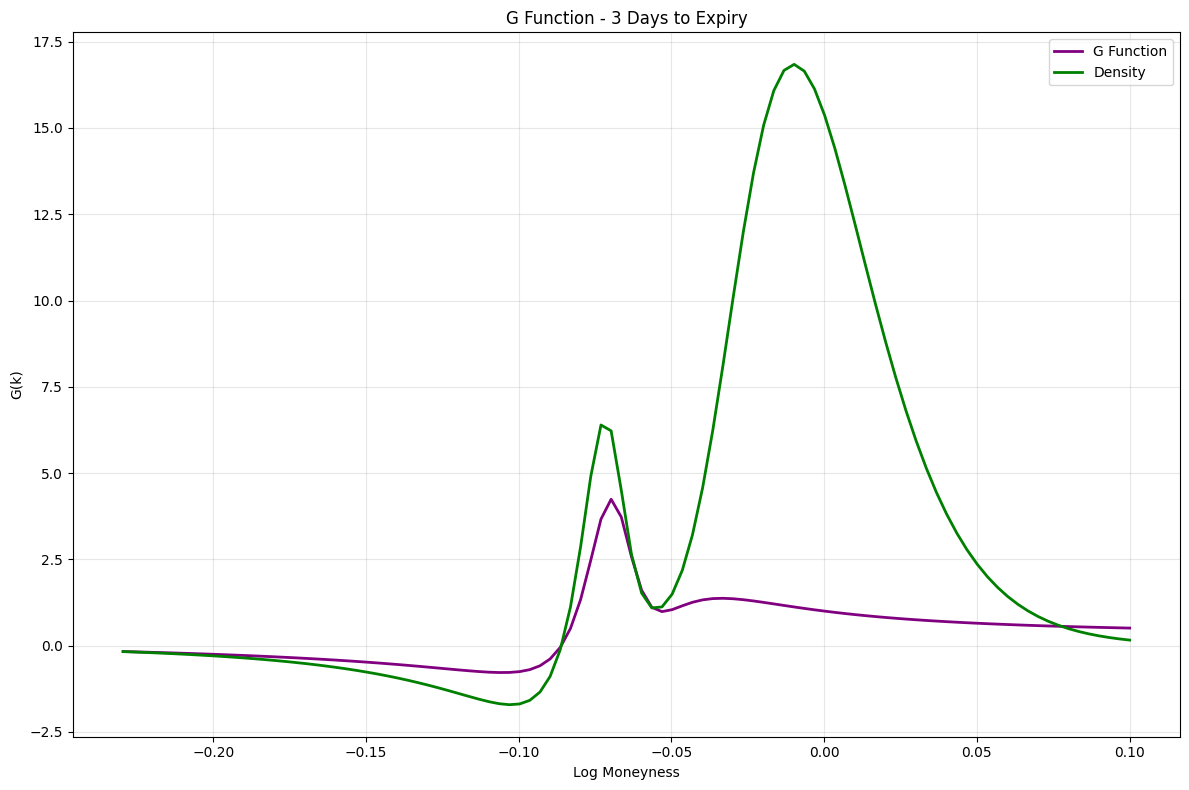

Found 25 options with 8 days to expiry
Moneyness range: -0.086 to 0.176


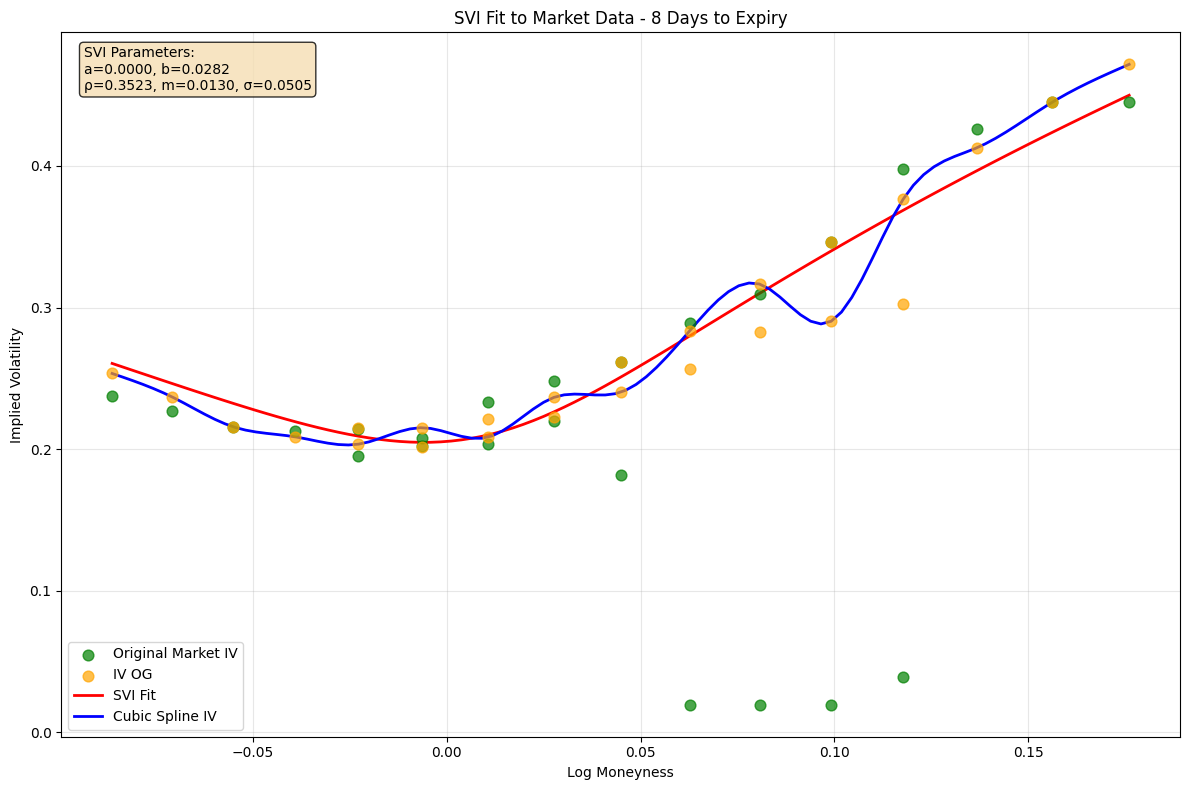

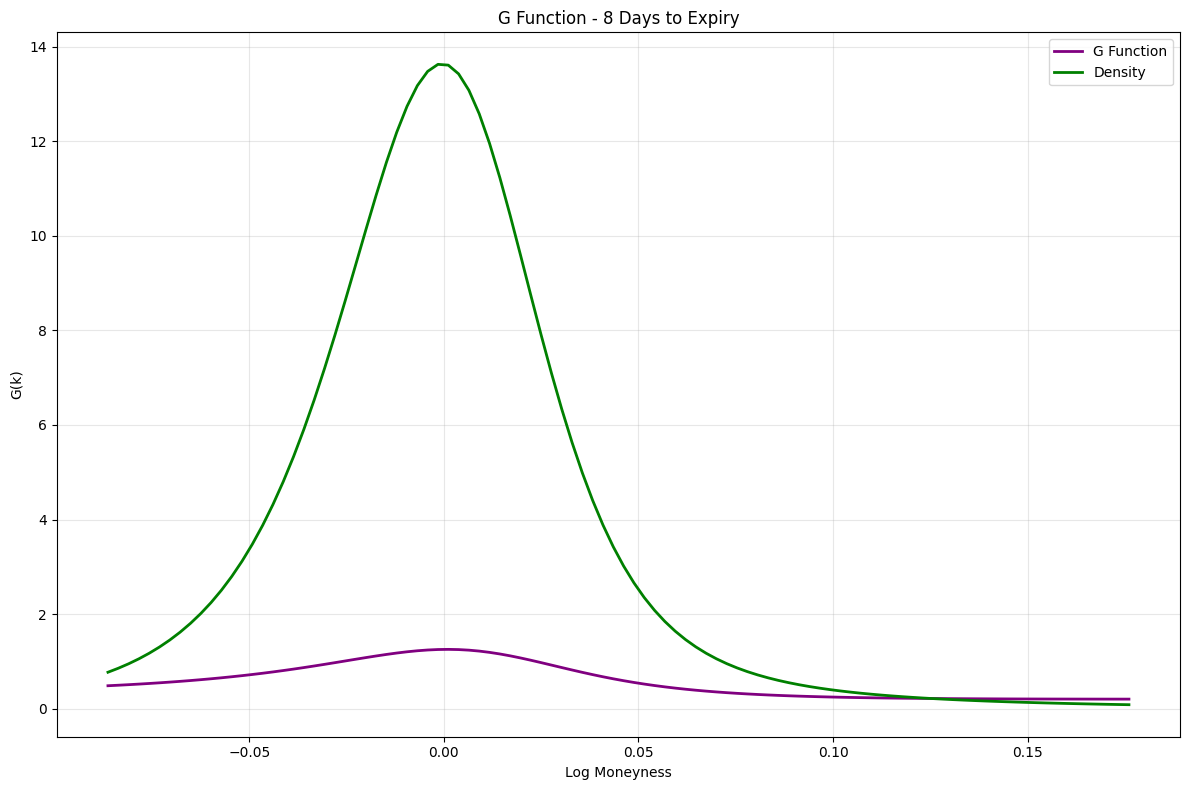

Found 12 options with 18 days to expiry
Moneyness range: -0.046 to 0.090


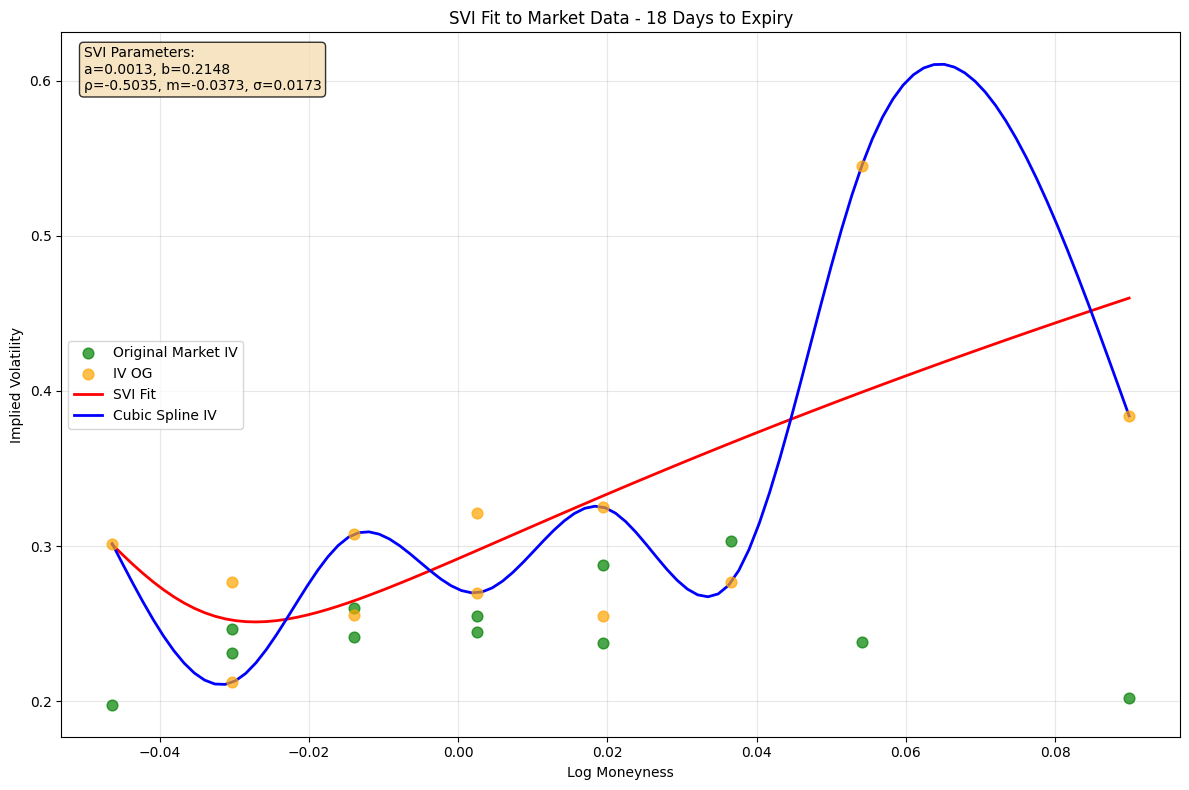

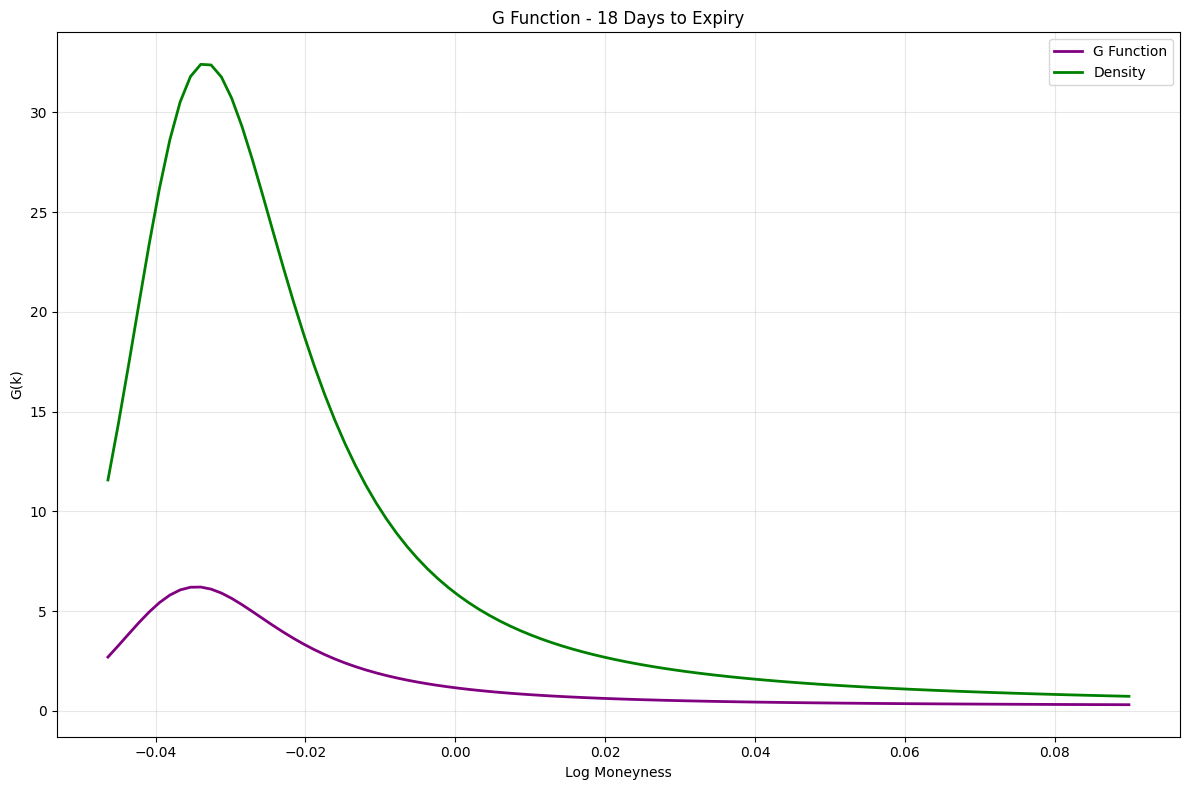

Found 105 options with 22 days to expiry
Moneyness range: -0.214 to 0.421


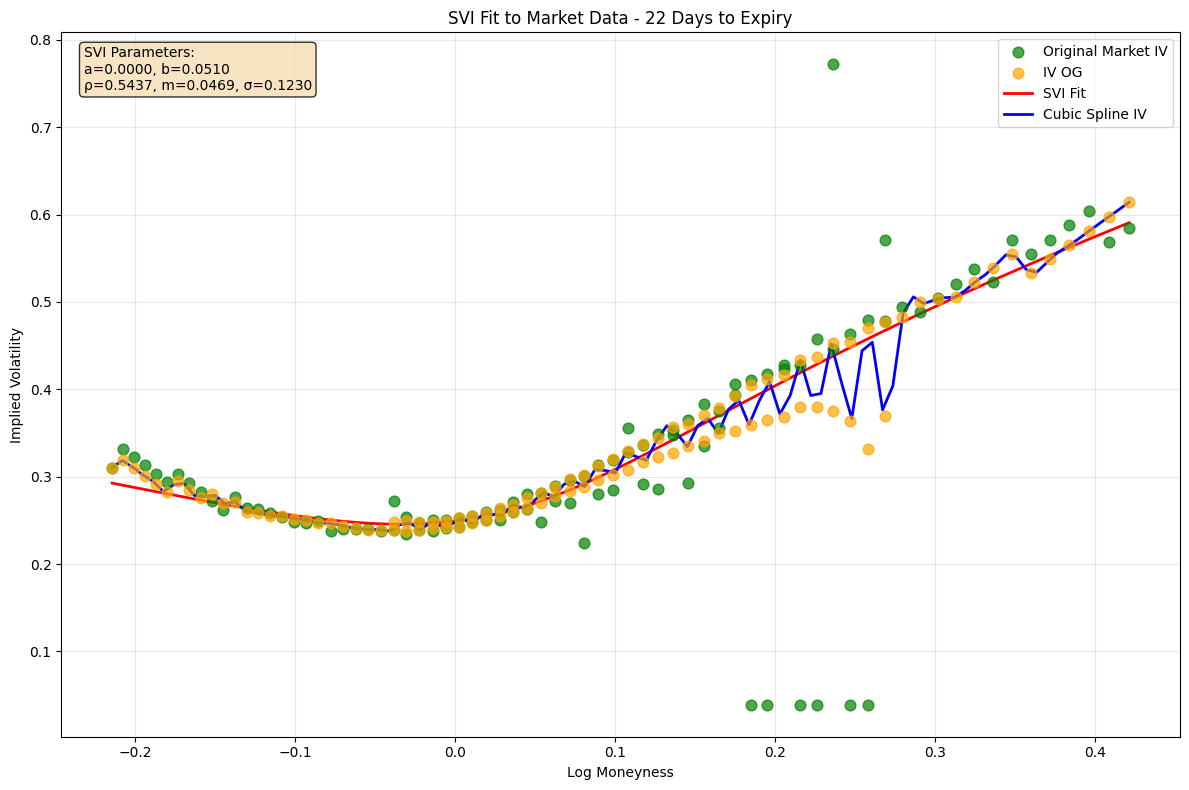

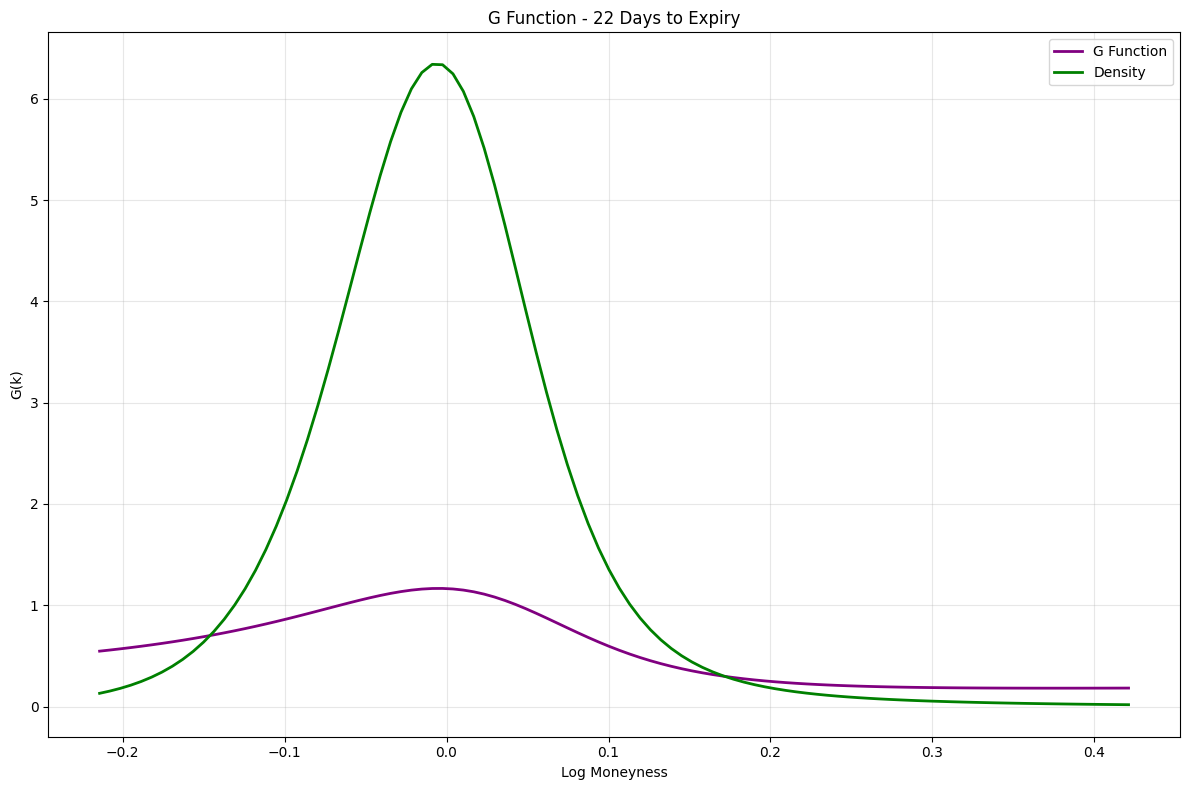

Found 16 options with 27 days to expiry
Moneyness range: -0.103 to 0.274


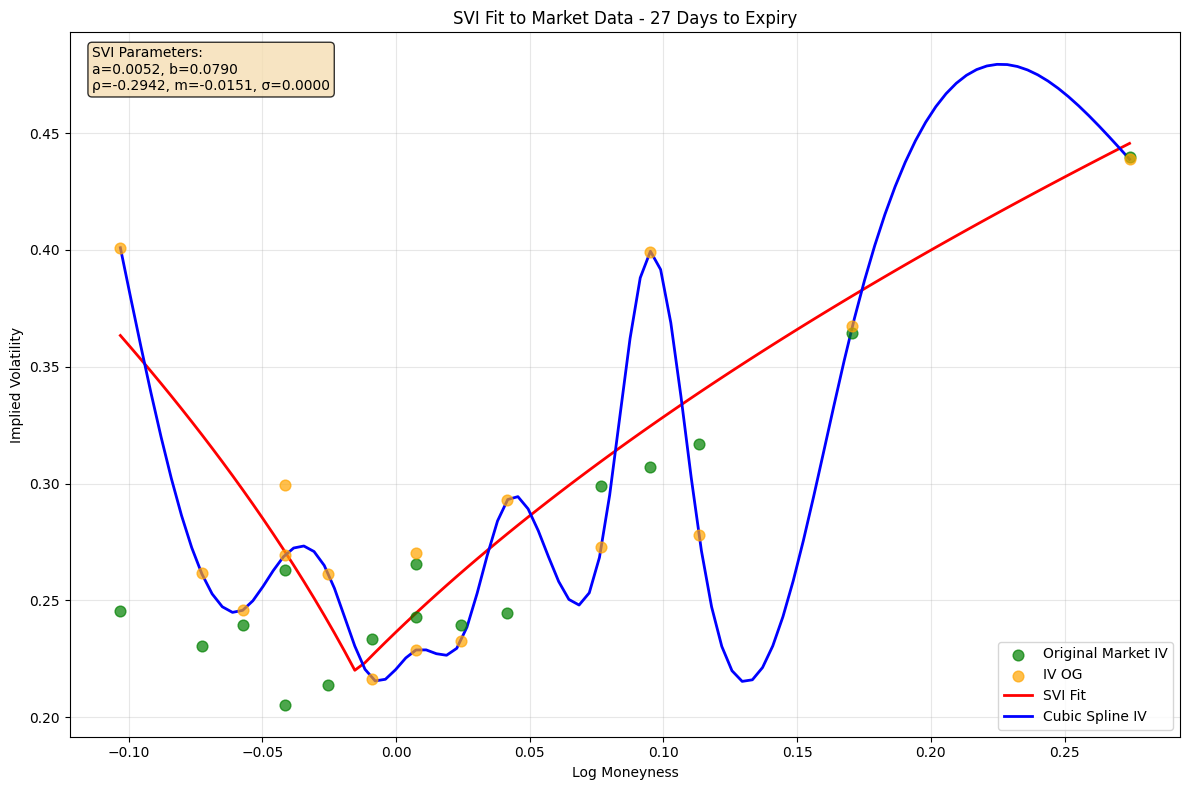

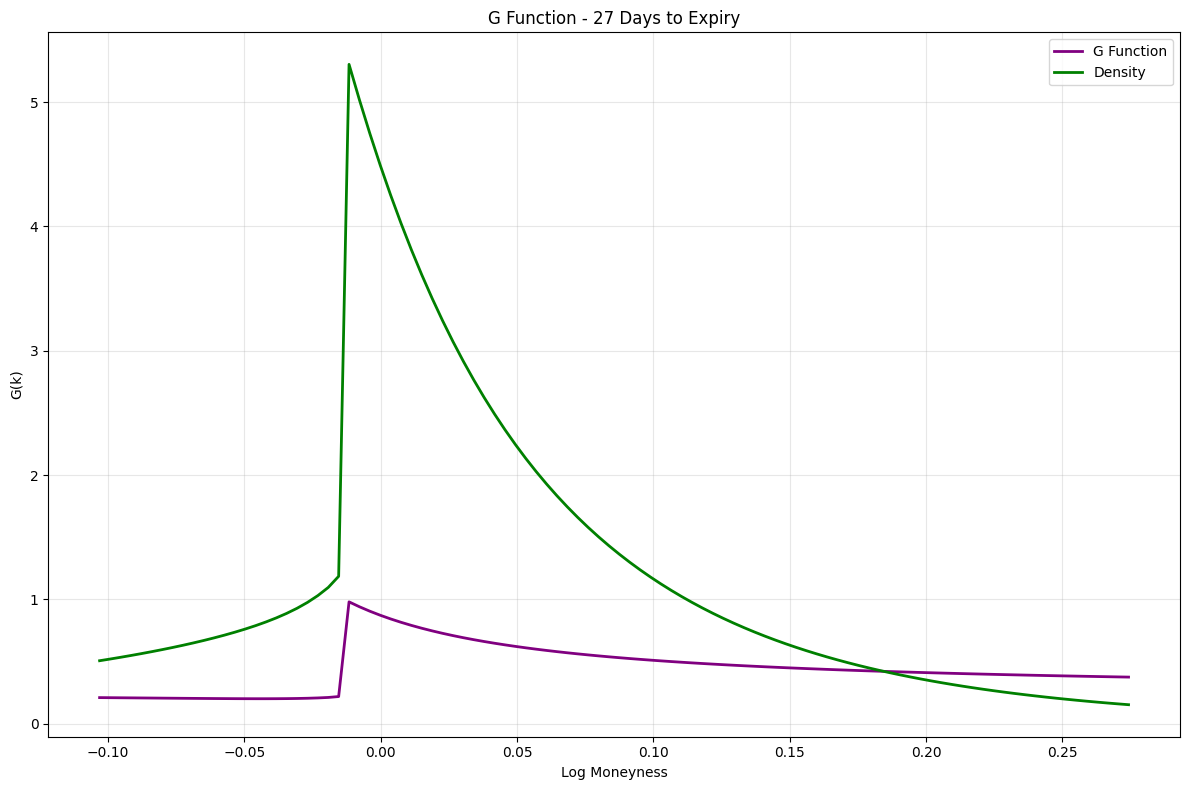

Found 134 options with 42 days to expiry
Moneyness range: -0.281 to 0.610


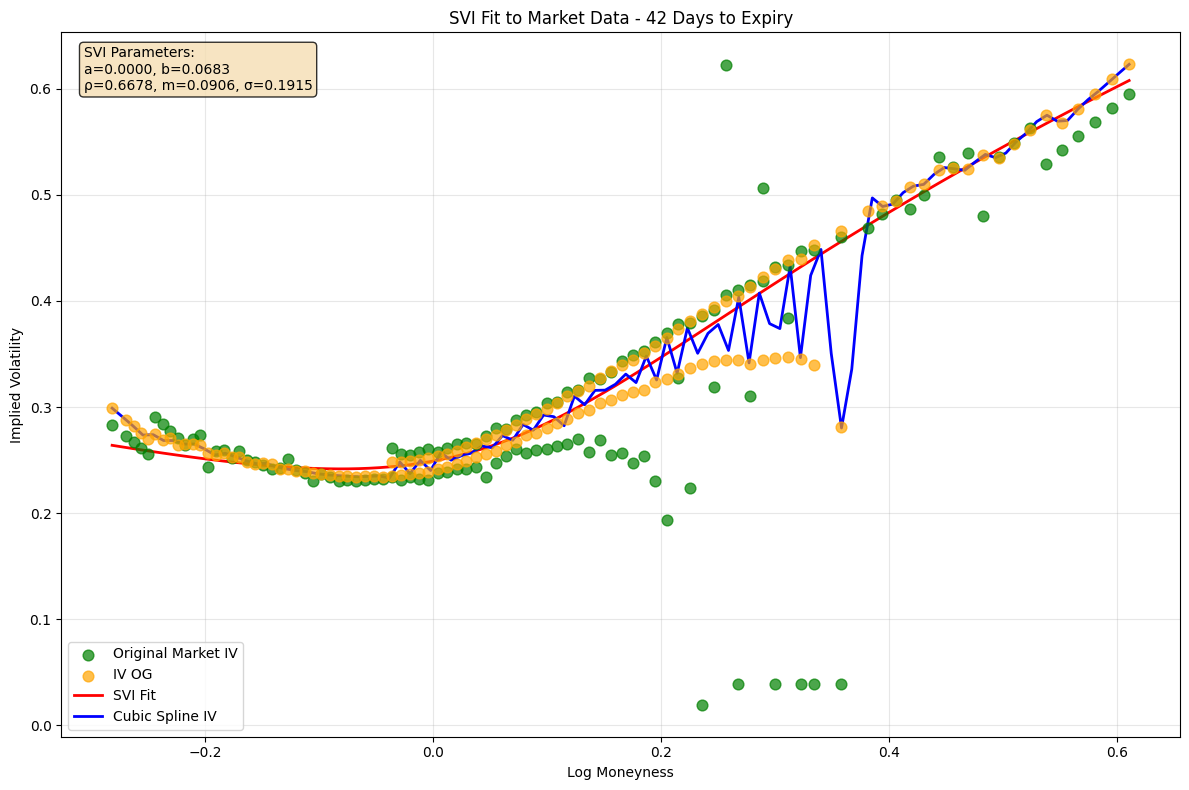

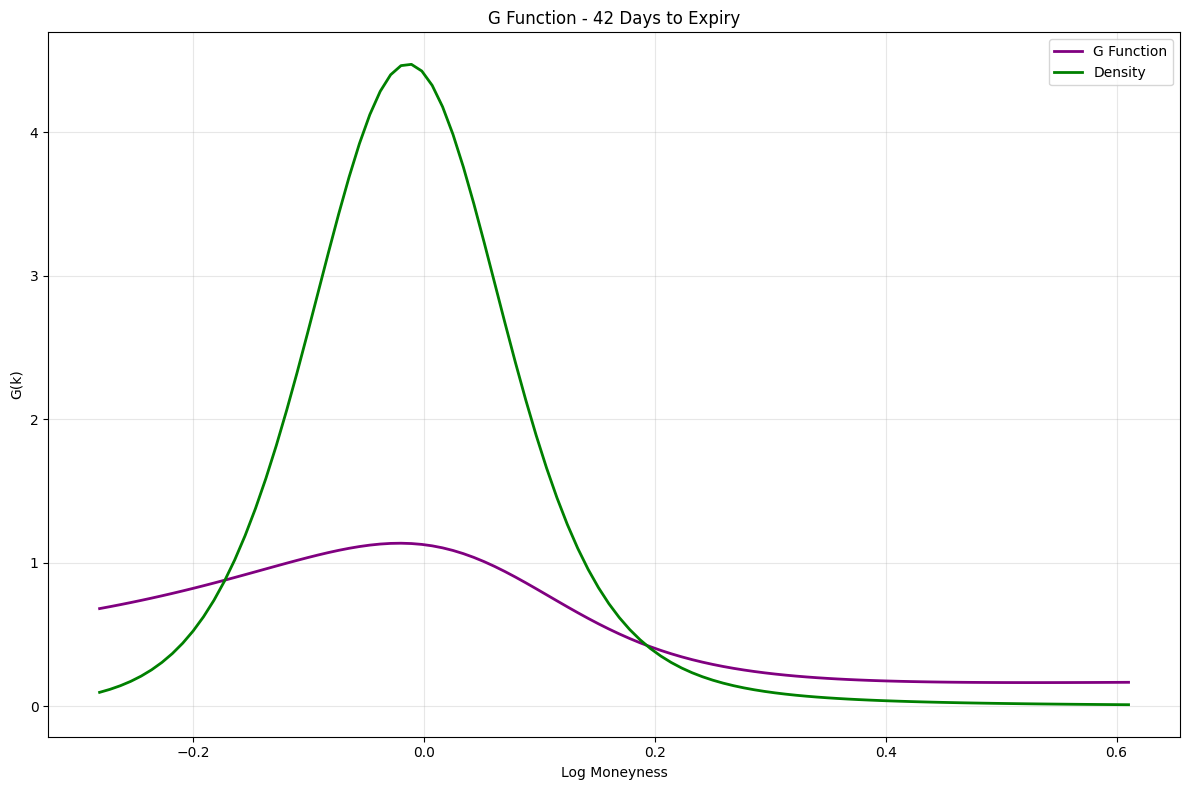

Found 43 options with 60 days to expiry
Moneyness range: -0.325 to 0.257


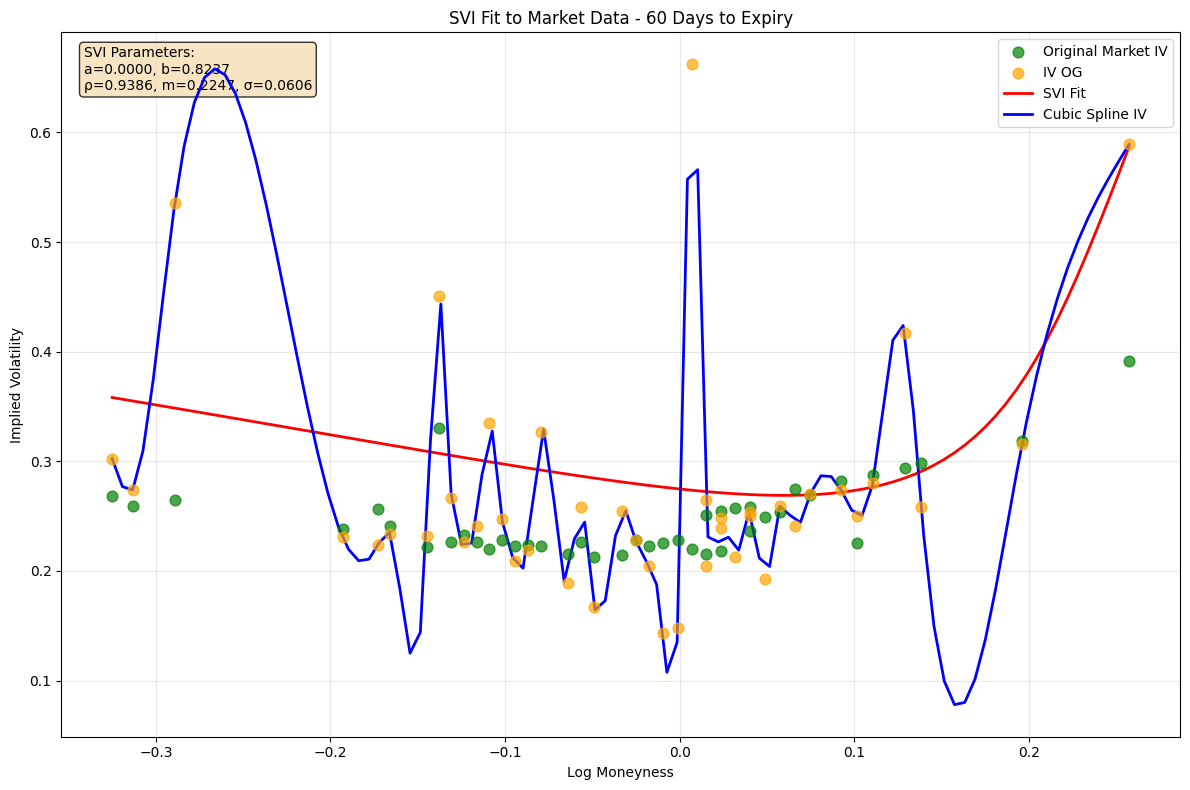

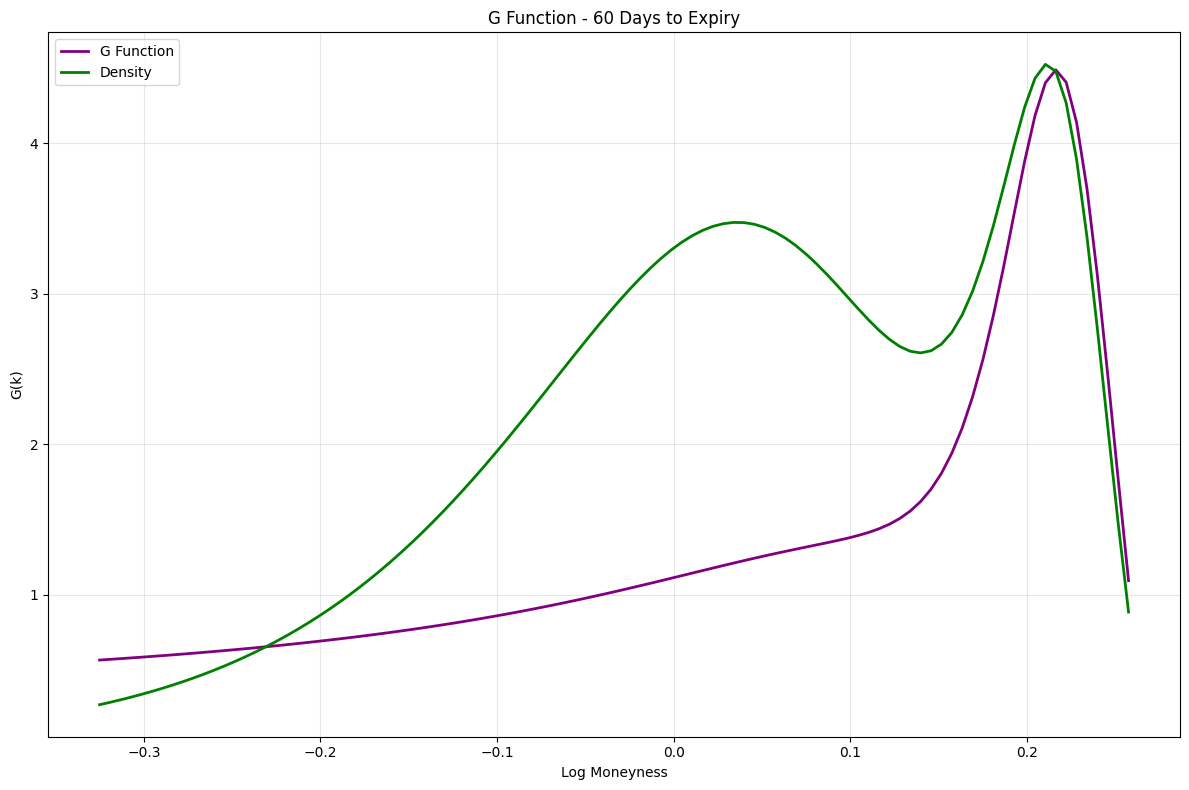

Found 21 options with 83 days to expiry
Moneyness range: -0.259 to 0.169


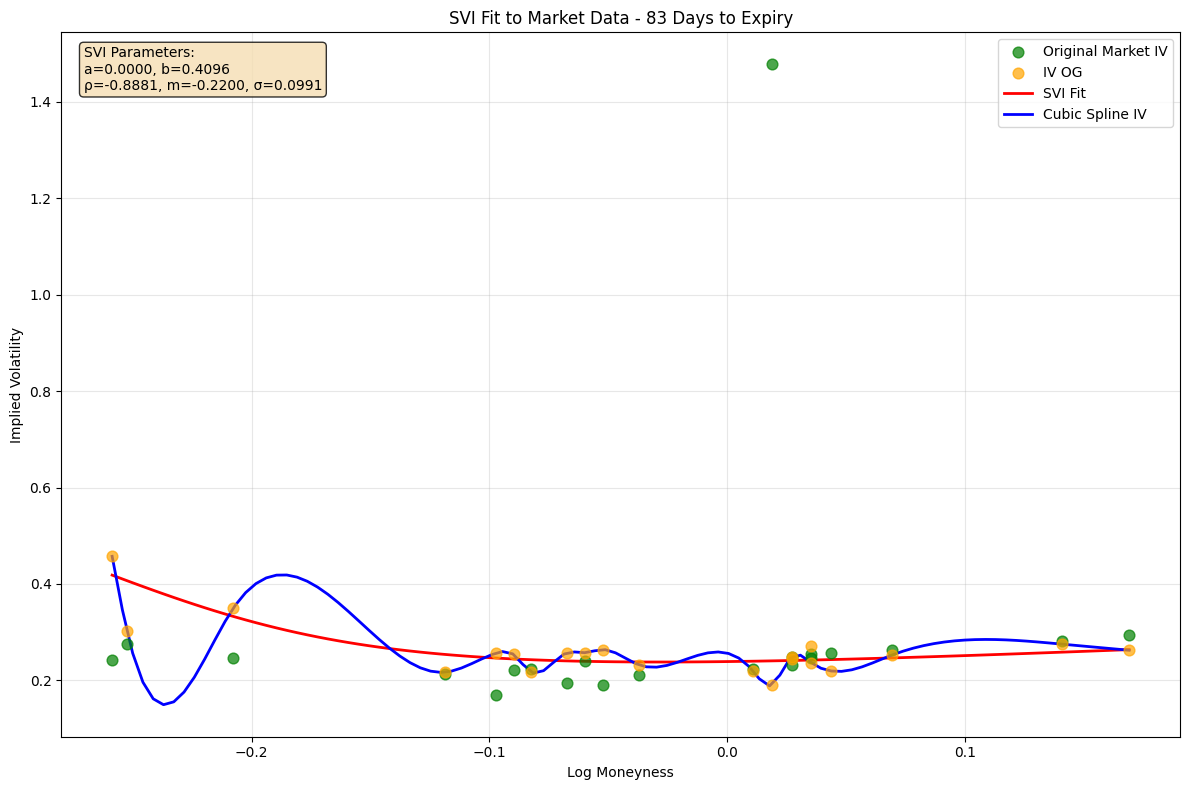

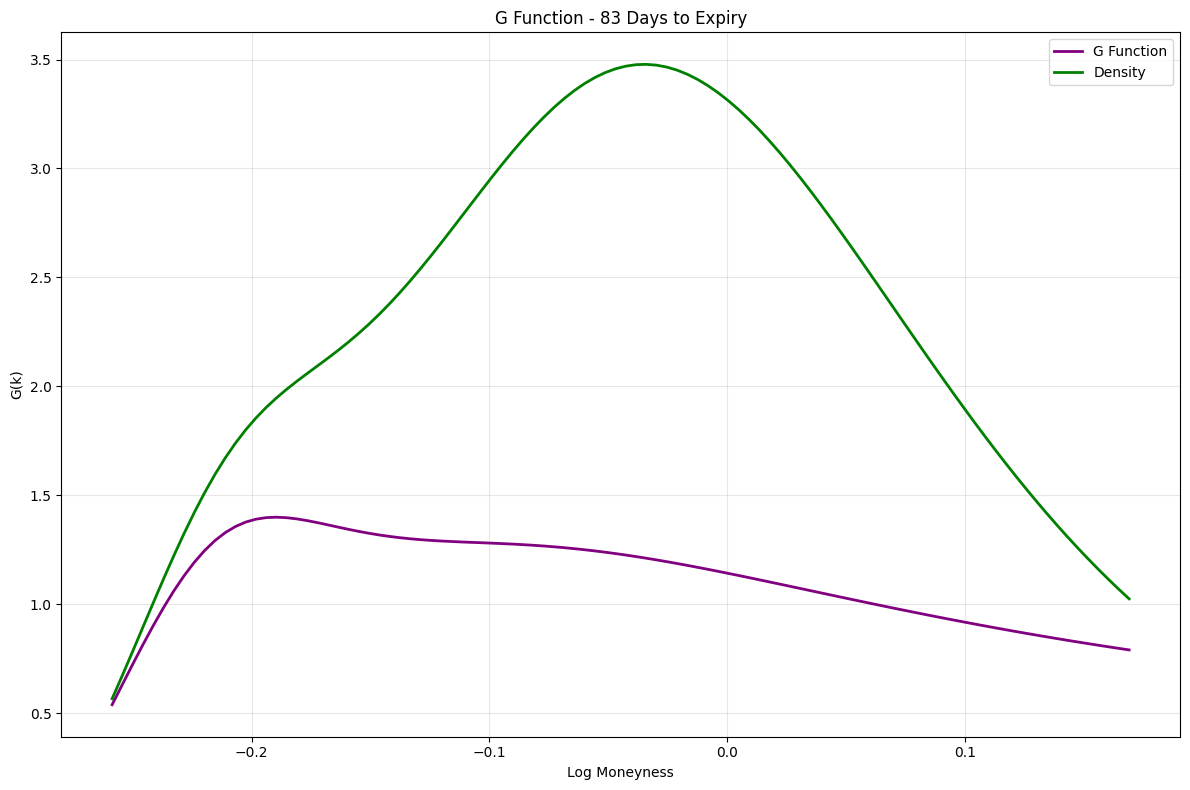

Found 8 options with 103 days to expiry
Moneyness range: -0.197 to 0.864


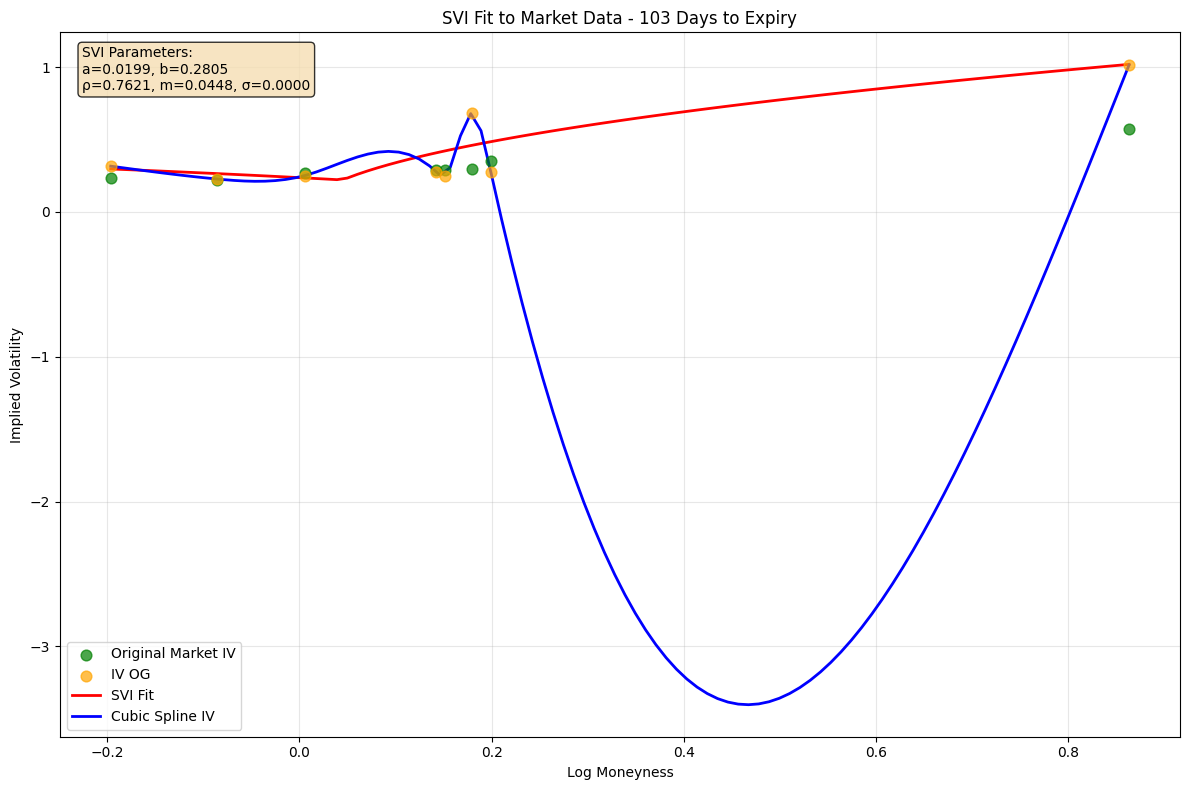

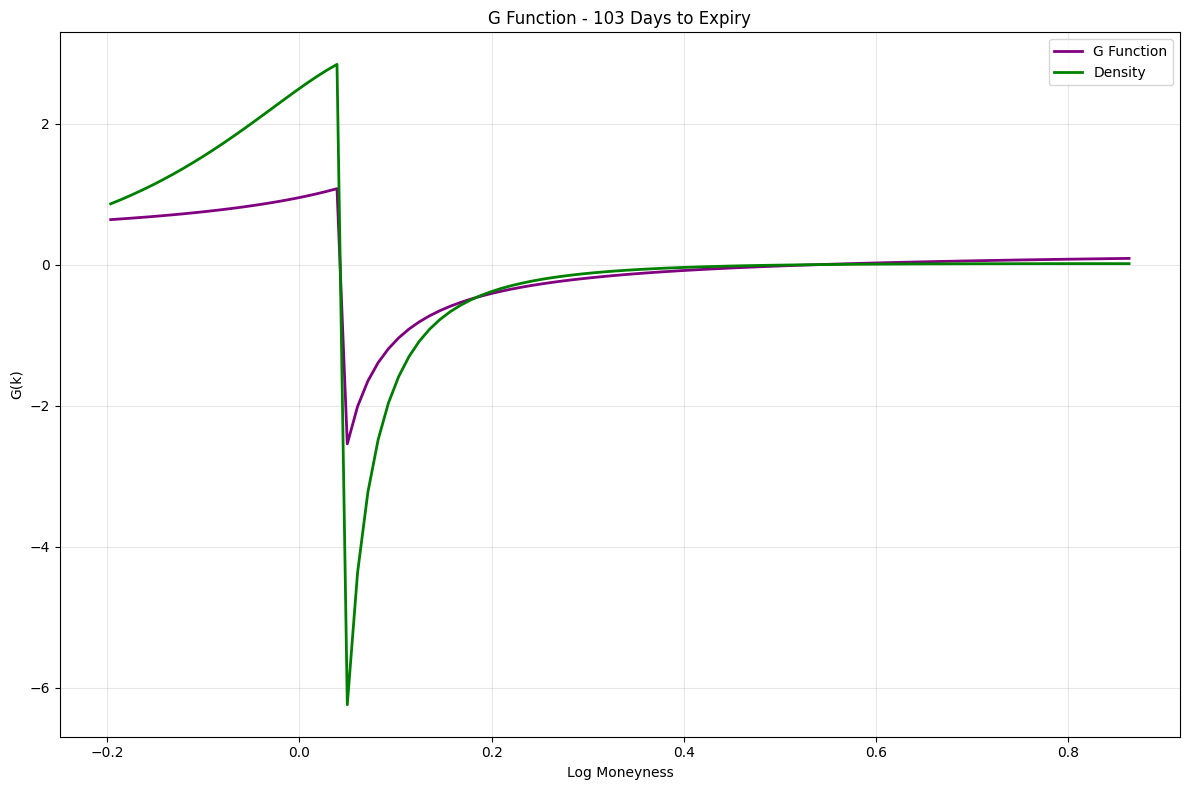

Found 26 options with 122 days to expiry
Moneyness range: -0.237 to 0.249


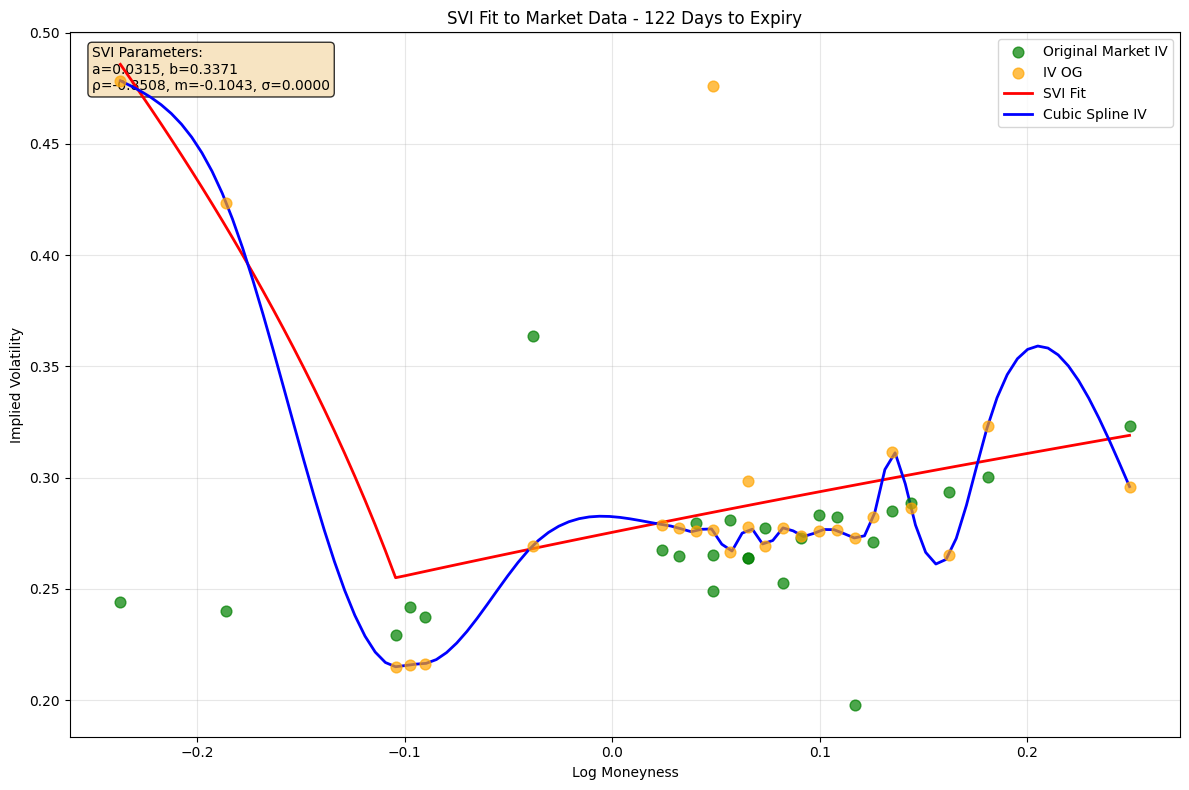

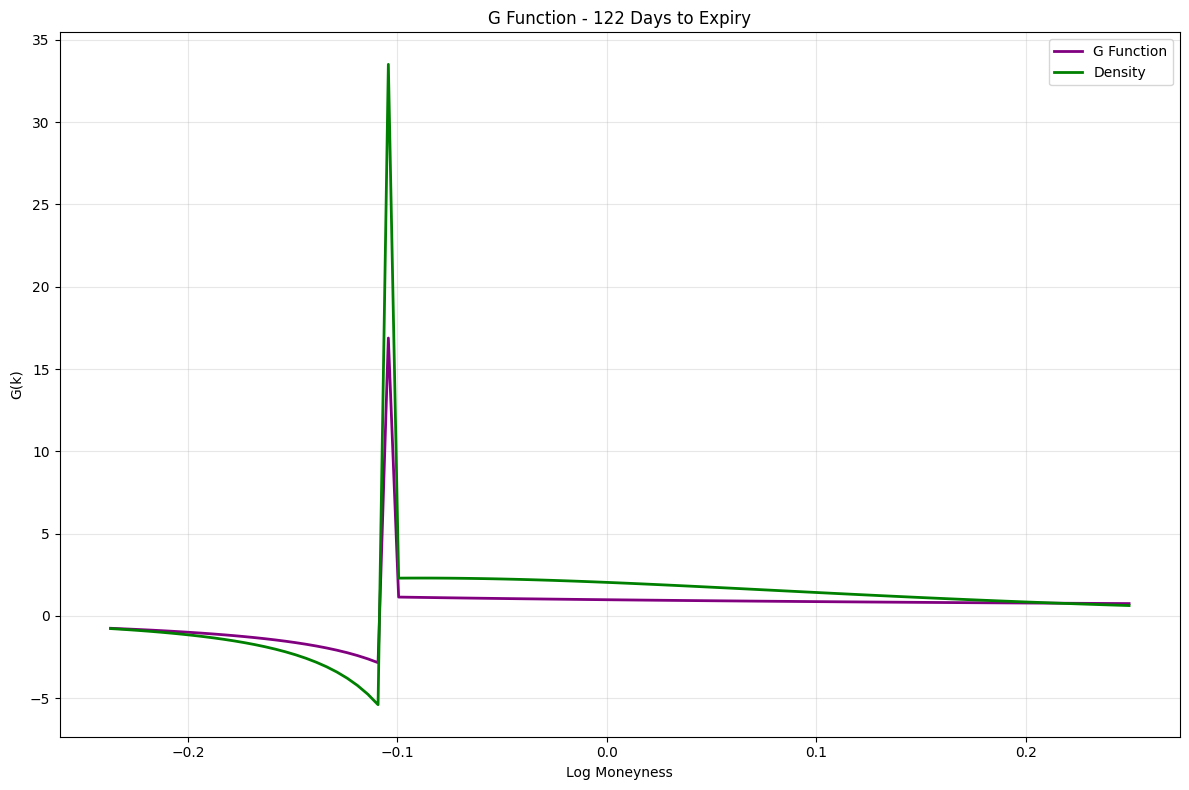

In [5]:
final_df.dropna(inplace=True)
for x in final_df['TTE_days'].unique():
    fitting = SingleExpiry(days_to_expiry=x, df=final_df)
    fitting.plot_svi()

In [6]:
# Step 3: Prepare data for SSVI calibration
# Group by expiry to get one slice per expiry
ssvi_data = final_df.groupby('TTE_years').agg({
    'Expiry': 'first',
    'theta': 'first',  # Average theta for this expiry
    'psi': 'first',    # Average psi for this expiry
    'p_t': 'first',    # Average p_t for this expiry
    'c_t': 'first',    # Average c_t for this expiry
    'svi_rho': 'first' # Average rho for this expiry
}).reset_index()

# # Rename columns to match SSVI requirements
# ssvi_data = ssvi_data.rename(columns={
#     'TTE_years': 'TTE_years',
#     'p_t': 'p_t',
#     'c_t': 'c_t'
# })

print(f"SSVI calibration data shape: {ssvi_data.shape}")
print(ssvi_data.head())

SSVI calibration data shape: (10, 7)
   TTE_years      Expiry     theta       psi       p_t       c_t   svi_rho
0   0.011905  24/10/2025  0.000516  0.133919  6.309208  0.321480 -0.903033
1   0.031746  31/10/2025  0.001293  0.039277  0.498614  1.040996  0.352285
2   0.071429  14/11/2025  0.007387  0.555169  4.139076  1.366938 -0.503475
3   0.087302  21/11/2025  0.005141  0.064932  0.316255  1.070061  0.543747
4   0.107143  28/11/2025  0.005610  0.359970  1.320143  0.719940 -0.294205


In [7]:
# Step 4: Run SSVI calibration
try:
    # Build calibrator with default settings
    calibrator, slice_provider = build_default_calibrator(
        df=ssvi_data,
        column_map=None,  # No column remapping needed if names match
        metadata_columns=['TTE_years']  # Include time to expiry in metadata
    )
    
    print("Calibrator built successfully")
    
    # Get slices to verify data
    slices = slice_provider.get_slices()
    print(f"Number of slices: {len(slices)}")
    for i, slice_obj in enumerate(slices[:3]):  # Show first 3
        print(f"Slice {i+1}: tau={slice_obj.tau:.3f}, theta={slice_obj.theta:.4f}, psi={slice_obj.psi:.4f}")
    
except Exception as e:
    print(f"Error building calibrator: {e}")
    import traceback
    traceback.print_exc()

Calibrator built successfully
Number of slices: 10
Slice 1: tau=0.012, theta=0.0005, psi=0.1339
Slice 2: tau=0.032, theta=0.0013, psi=0.0393
Slice 3: tau=0.071, theta=0.0074, psi=0.5552


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\surfaces\ssvi2.py:660: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  expiry=pd.to_datetime(row["Expiry"]),


In [8]:
# Step 5: Run the calibration
try:
    print("Starting SSVI calibration...")
    
    # Run calibration
    result = calibrator.calibrate(
        initial_guess=(0.0, 1.0, 0.5)  # (rho, eta, gamma)
    )
    
    print(f"\n=== CALIBRATION RESULTS ===")
    print(f"Status: {result.status}")
    print(f"Message: {result.message}")
    print(f"Objective value: {result.objective_value:.6f}")
    print(f"Parameters:")
    print(f"  rho (correlation): {result.params.rho:.4f}")
    print(f"  eta (scaling): {result.params.eta:.4f}")
    print(f"  gamma (curvature): {result.params.gamma:.4f}")
    
    # Show error summary
    print(f"\nMax absolute errors: {result.max_abs_errors}")
    print(f"Max relative errors: {result.max_rel_errors}")
    
except Exception as e:
    print(f"Calibration failed: {e}")
    import traceback
    traceback.print_exc()

Starting SSVI calibration...
Calibration failed: psi must be at least 2 * max(p, c).


Traceback (most recent call last):
  File "C:\Users\pedro.hun\AppData\Local\Temp\ipykernel_79724\4286549244.py", line 6, in <module>
    result = calibrator.calibrate(
        initial_guess=(0.0, 1.0, 0.5)  # (rho, eta, gamma)
    )
  File "c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\surfaces\ssvi2.py", line 540, in calibrate
    slices = list(self._validated_slices())
  File "c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\surfaces\ssvi2.py", line 568, in _validated_slices
    slc.validate()
    ~~~~~~~~~~~~^^
  File "c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\surfaces\ssvi2.py", line 78, in validate
    raise InvalidSliceError("psi must be at least 2 * max(p, c).")
src.core.surfaces.ssvi2.InvalidSliceError: psi must be at least 2 * max(p, c).
